<div style="text-align:center;">
    <h1 style="font-size: 50px; margin: 0px; margin-bottom: 5px;">Initial-Core-Final Mass Relation Plot</h1>
    <h2 style="margin:0px; margin-bottom: 5px;">COMPAS methods paper Figure 8</h2>
    <p style="text-align:center;">A notebook for reproducing the initial-core-final mass relation plot in the COMPAS methods paper.</p>
</div>

<img src="https://compas.science/images/COMPAS_CasA.png" style="width:50%; display:block; margin:auto; margin-bottom:20px">

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import astropy.constants as consts
import matplotlib
import astropy.units as u

In [2]:
# make the plots pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 24

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

# Get the stellar types
First we can import the stellar types array to use the same colour palette as the other plots.

In [3]:
import sys
sys.path.append("../")
from stellar_types import stellar_types

# Get the data

In [4]:
def get_COMPAS_vars(file, group, var_list):
    if isinstance(var_list, str):
        return file[group][var_list][...]
    else:
        return [file[group][var][...] for var in var_list]

# Top panel: Solar metallicity default prescription

In [5]:
def core_remnant_mass_comparison(file, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        
    with h5.File(file, "r") as compas:    
        m_ZAMS, m_final, m_co_core_atCO, Z, stellar_type = get_COMPAS_vars(compas, "SSE_System_Parameters",
                                                                           ["Mass@ZAMS",
                                                                            "Mass",
                                                                            "Mass_CO_Core@CO",
                                                                            "Metallicity",
                                                                            "Stellar_Type"])

    # only plot things for solar metallicity
    solar = Z == 0.01416
    uni_types = np.unique(stellar_type[solar])
    
    # annotate the plot with the stellar types
    for i in range(len(uni_types)):
        ax.annotate(stellar_types[uni_types[i]]["short"], xy=(0.02, 0.93 - 0.05 * i),
                    xycoords="axes fraction", color=plt.get_cmap("tab10")(i / 10), fontsize=0.7*fs, weight="bold")
    
    
    for i in range(len(uni_types)):
        # plot the final white dwarf mass for WDs
        if uni_types[i] in [10, 11, 12]:
            ax.loglog(m_ZAMS[solar][stellar_type[solar] == uni_types[i]],
                           m_final[solar][stellar_type[solar] == uni_types[i]],
                           lw=3, color=plt.get_cmap("tab10")(i / 10))
        # plot CO core mass at CO formation for NSs and BHs
        elif uni_types[i] in [13, 14]:
            ax.loglog(m_ZAMS[solar][stellar_type[solar] == uni_types[i]],
                      m_co_core_atCO[solar][stellar_type[solar] == uni_types[i]],
                      lw=3, color=plt.get_cmap("tab10")(i / 10))

    # annotate with solar metallicity
    ax.annotate(r"$Z = Z_{\rm \odot}$", xy=(0.97, 0.04), xycoords="axes fraction", fontsize=0.7*fs, ha="right")
    
    ax.set_ylabel(r"Core Mass $[\rm M_{\odot}]$")
    
    if show:
        plt.show()
        
    return fig, ax

# Middle panel: Illustrate effect of metallicity on core masses

In [6]:
def remnant_mass_across_metallicity(file, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        
    with h5.File(file, "r") as compas:    
        m_ZAMS, m_final, m_co_core_atCO, Z, stellar_type = get_COMPAS_vars(compas, "SSE_System_Parameters",
                                                           ["Mass@ZAMS",
                                                            "Mass",
                                                            "Mass_CO_Core@CO",
                                                            "Metallicity",
                                                            "Stellar_Type"])
        
    # create an inset axis for the linear version
    inset_ax = ax.inset_axes([0.05, 0.55, 0.53, 0.425])
    inset_ax.tick_params(labelsize=0.5*fs)
    
    # plot three different metallicities
    for Z_match, style in [(0.01, "-"), (0.001, "--"), (0.0001, "dotted")]:
        matching_Z = Z == Z_match
        uni_types = np.unique(stellar_type[matching_Z])
        for i in range(len(uni_types)):
            # plot in same way as top panel
            matching_type = stellar_type[matching_Z] == uni_types[i]
            y_quantity = m_final if uni_types[i] in [10, 11, 12] else m_co_core_atCO
            ax.loglog(m_ZAMS[matching_Z][matching_type], y_quantity[matching_Z][matching_type],
                       lw=2, linestyle=style, markevery=25, color=plt.get_cmap("tab10")(i / 10),
                       label=r"$Z = {{{}}}$".format(Z_match) if i == len(uni_types) - 1 else None)

            # for black holes also plot in the inset axis
            if uni_types[i] == 14:
                inset_ax.plot(m_ZAMS[matching_Z][matching_type], y_quantity[matching_Z][matching_type],
                               lw=2, linestyle=style, markevery=25, color=plt.get_cmap("tab10")(i / 10))

    ax.legend(loc="lower right", fontsize=0.7 * fs)
    
    ax.set_ylabel(r"Core Mass $[\rm M_{\odot}]$")
    
    if show:
        plt.show()
    
    return fig, ax

# Bottom panel: Demonstrate how remnant mass prescriptions differ at solar metallicity

In [7]:
def remnant_mass_prescription_comparison(prescriptions, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    for file, style, label in prescriptions:
        with h5.File("COMPAS_Output_{}/COMPAS_Output_{}.h5".format(file, file), "r") as compas:    
            m_ZAMS, m_final, Z, stellar_type = get_COMPAS_vars(compas, "SSE_System_Parameters",
                                                               ["Mass@ZAMS",
                                                                "Mass",
                                                                "Metallicity",
                                                                "Stellar_Type"])

        solar = Z == 0.01416
        uni_types = np.unique(stellar_type[solar])
        for i in range(len(uni_types)):
            # only plot the NSs and BHs
            if uni_types[i] >= 13:
                # use scatter points for the Mandel & Mueller prescription
                if file == "MM20":
                    ax.scatter(m_ZAMS[solar][stellar_type[solar] == uni_types[i]],
                                    m_final[solar][stellar_type[solar] == uni_types[i]],
                                    s=0.2, alpha=0.5, color=plt.get_cmap("tab10")(i / 10),
                                    label=label if i == len(uni_types) - 1 else None)
                    
                # use lines for the other ones
                else:
                    ax.loglog(m_ZAMS[solar][stellar_type[solar] == uni_types[i]],
                                   m_final[solar][stellar_type[solar] == uni_types[i]],
                                   lw=2, linestyle=style, color=plt.get_cmap("tab10")(i / 10),
                                   label=label if i == len(uni_types) - 1 else None, zorder=10)

    ax.set_xscale("log")
    ax.set_yscale("log")
    leg = ax.legend(fontsize=0.7 * fs, loc="lower right", markerscale=25, title=r"$Z = Z_{\rm \odot}$")
    leg.get_title().set_fontsize(0.7 * fs)
    
    ax.set_ylabel(r"Remnant Mass $[\rm M_{\odot}]$")
    
    if show:
        plt.show()
        
    return fig, ax

# Create the whole plot!

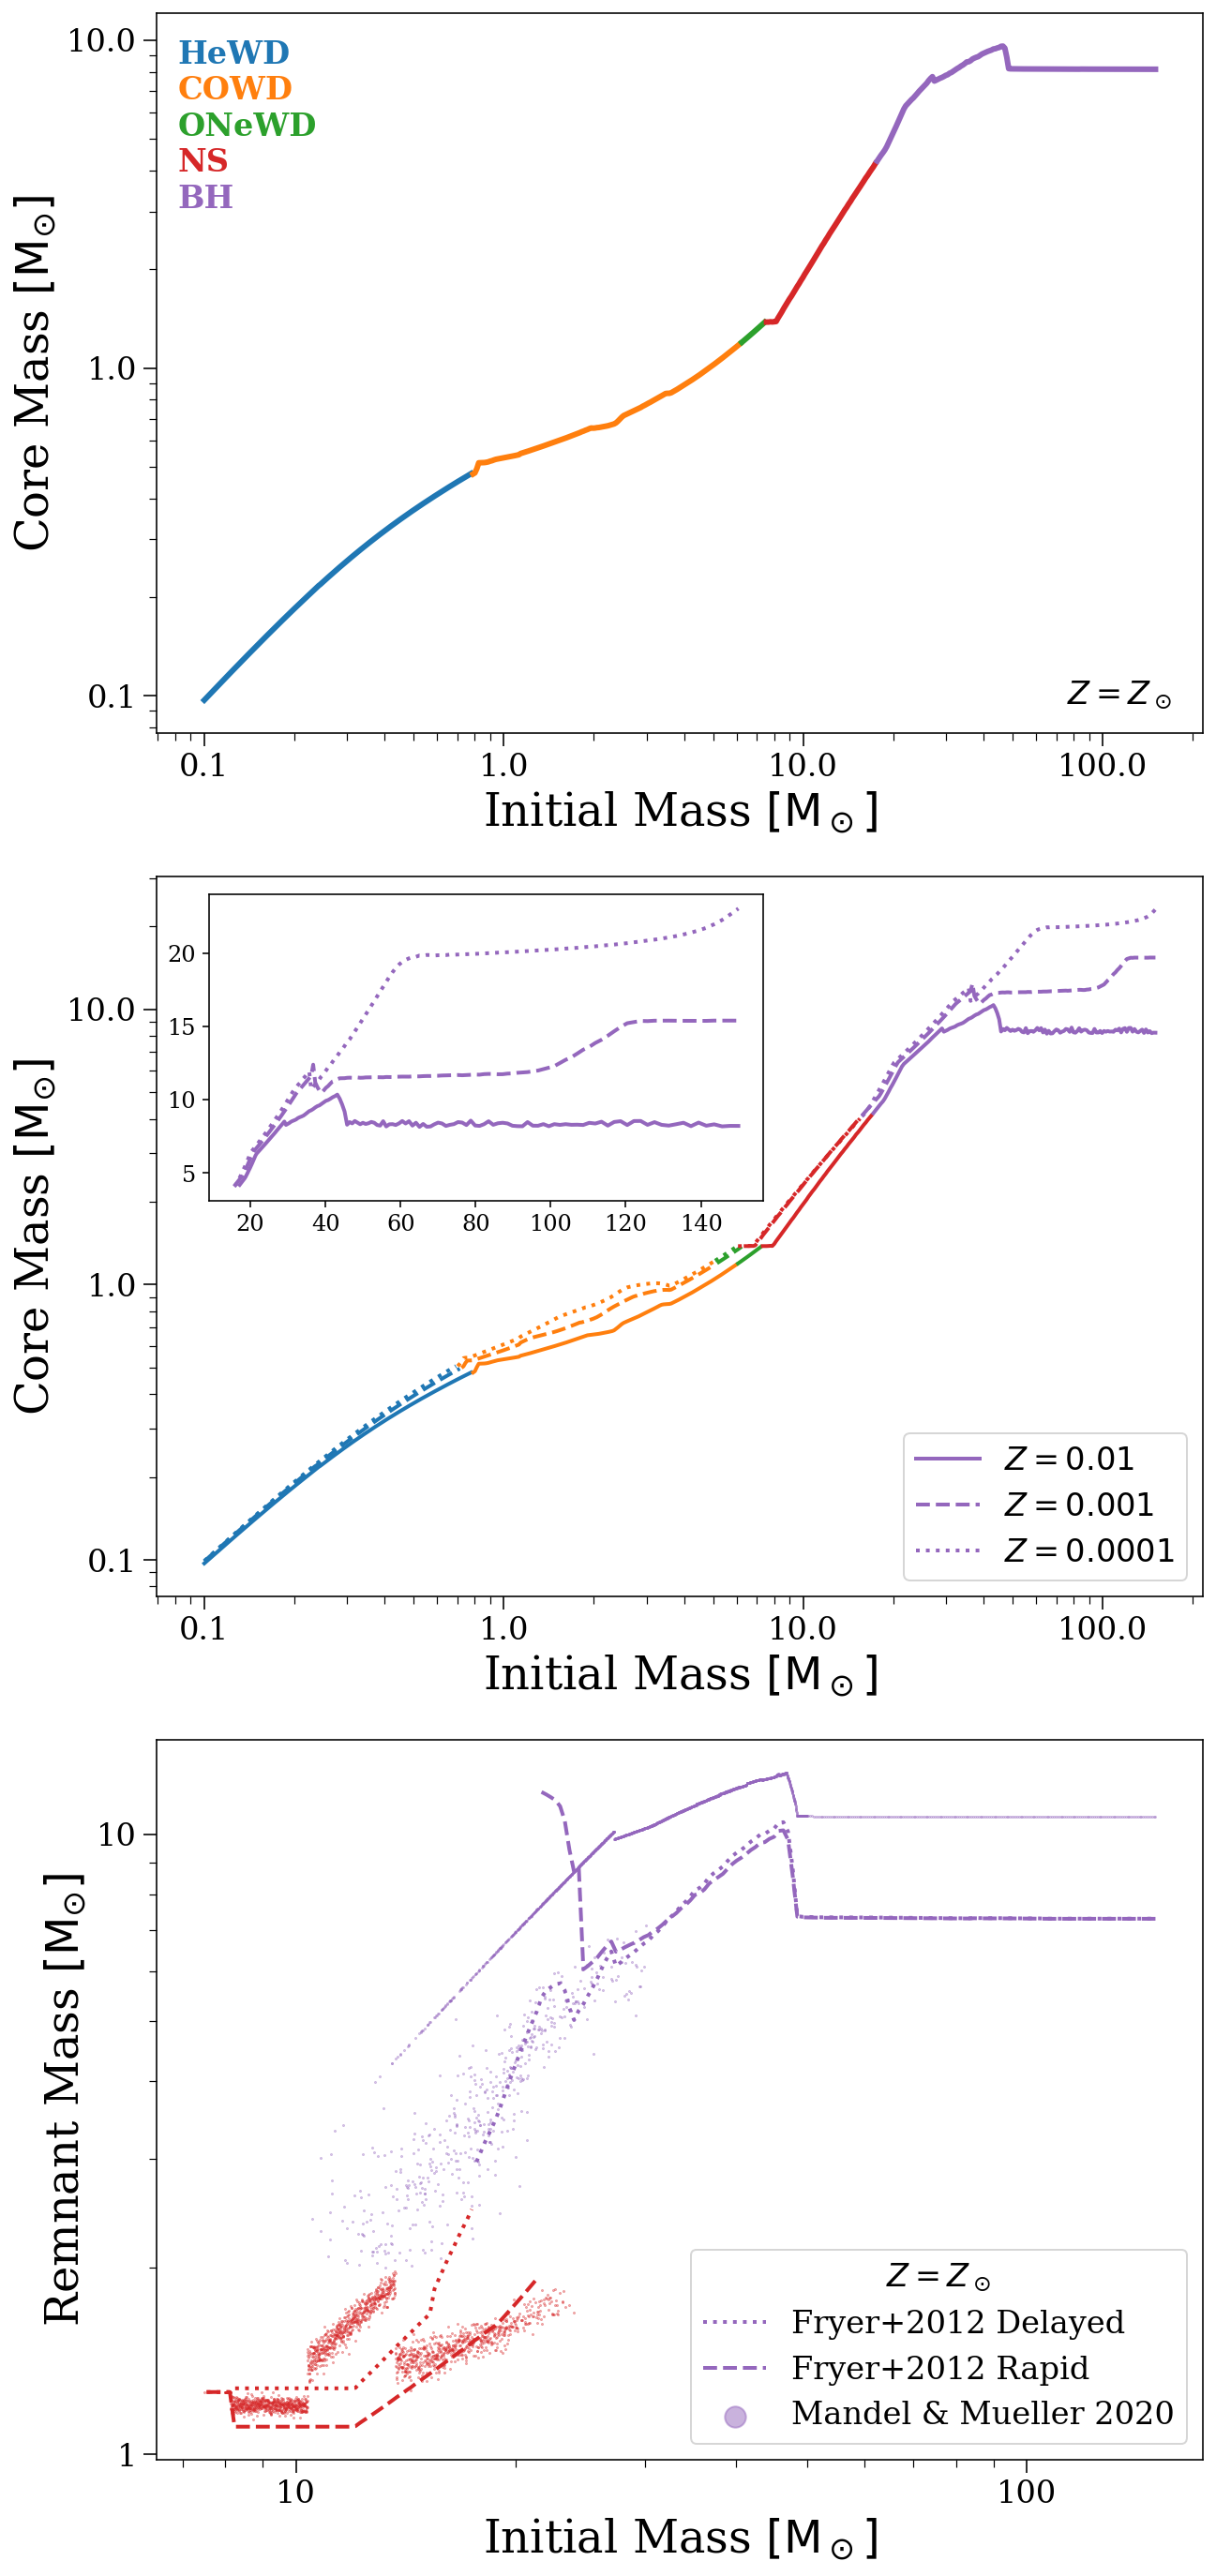

In [8]:
fig, axes = plt.subplots(3, figsize=(10, 24))
    
fig, axes[0] = core_remnant_mass_comparison("COMPAS_Output_default/COMPAS_Output_default.h5",
                                        fig=fig, ax=axes[0], show=False)

fig, axes[1] = remnant_mass_across_metallicity("COMPAS_Output_default/COMPAS_Output_default.h5",
                                        fig=fig, ax=axes[1], show=False)

fig, axes[2] = remnant_mass_prescription_comparison([("default", "dotted", "Fryer+2012 Delayed"),
                                                     ("rapid", "--", "Fryer+2012 Rapid"),
                                                     ("MM20", None, "Mandel & Mueller 2020")],
                                                    fig=fig, ax=axes[2], show=False)

for ax, xticks, yticks in zip(axes,
                              [[0.1, 1, 10, 100], [0.1, 1, 10, 100], [10.0, 100.0]],
                              [[0.1, 1, 10], [0.1, 1, 10], [1.0, 10.0]]):
    ax.set_xticks(xticks)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel(r"Initial Mass $[\rm M_{\rm \odot}]$")
    
    ax.set_yticks(yticks)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.tick_params(which="major", length=7)
    ax.tick_params(which="minor", length=4)
    
plt.savefig("initial_core_final_mass_relations.pdf", format="pdf", bbox_inches="tight")
    
plt.show()